# Seasonal means along the 3-year period

In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfea
import xarray as xr

from dask.diagnostics import ProgressBar
from matplotlib import cm
from os.path import exists

ProgressBar().register()

Data location:

In [2]:
var = 'pr'
period = slice('2018-06-01','2021-05-31')

urls = {
  'UCAN-WRF433' : 'https://data.meteo.unican.es/thredds/dodsC/CORDEX/fps/sesa/ncml/CORDEX/output/CSAM-4i/UCAN/ECMWF-ERA5/evaluation/r1i1p1f1/UCAN-WRF433/v1/day/v20220727/CORDEX_output_CSAM-4i_ECMWF-ERA5_evaluation_r1i1p1f1_UCAN-WRF433_v1_day_v20220727',
  'USP-RegCM471' : 'https://data.meteo.unican.es/thredds/dodsC/CORDEX/fps/sesa/output/CORDEX/output/CSAM-4i/USP/ECMWF-ERA5/historical/r1i1p1f1/USP-RegCM471/v0/3hr/CORDEX_output_CSAM-4i_ECMWF-ERA5_historical_r1i1p1f1_USP-RegCM471_v0_3hr', 
  'ERA5' : 'https://data.meteo.unican.es/thredds/dodsC/CORDEX/fps/sesa/reanalysis/ERA5-CSAM-4i_day',
  'MSWX' : 'https://data.meteo.unican.es/thredds/dodsC/CORDEX/fps/sesa/mswx/CSAM-4i_GloH2O-MSWX_3hr'
}

scale = dict(
  pr = 86400., # kg/m2/s -> mm/day
)

Some functions to load data statistics and caching the results:

In [3]:
def load_yseasmean(nc, url, var, scale = 1.0):
  if exists(nc):
    yseasmean = xr.open_dataset(nc)[var]
    print(f'Data loaded from cache: {nc}')
  else:
    if type(url) == type([]):
      ds = xr.open_mfdataset(url, chunks = dict(time = 100, lon = 100, lat = 100))
    else:
      ds = xr.open_dataset(url, chunks = dict(time = 100, lon = 100, lat = 100))
    yseasmean = ds[var].sel(dict(time=period)).resample(time = 'QS-DEC').mean(dim='time').compute() * scale
    yseasmean.to_netcdf(nc, format = 'NETCDF4', encoding={var:{'zlib':True}})
  return(yseasmean)    

In [4]:
def load_seasfreq(nc, url, var, scale = 1.0):
  if var != 'pr':
    print(f'This function is only intended for precipitation. Variable passed: {var}')
    return()
  if exists(nc):
    rval = xr.open_dataset(nc)[var]
    print(f'Data loaded from cache: {nc}')
  else:
    if type(url) == type([]):
      ds = xr.open_mfdataset(url, chunks = dict(time = 100, lon = 100, lat = 100))
    else:
      ds = xr.open_dataset(url, chunks = dict(time = 100, lon = 100, lat = 100))
    rval = (
      (((ds[var].sel(dict(time=period)) * scale) > 0.1) * 1.0)
        .groupby('time.season')
        .mean(dim='time')
#        .sortby(xr.DataArray(['JJA', 'SON','DJF','MAM'], dims=['season']))
        .compute()
    )
    rval.to_netcdf(nc, format = 'NETCDF4', encoding={var:{'zlib':True}})
  return(rval)    

Wrapper to plot maps in panels

In [5]:
def facet_plot(yseasmean, title):
  fg = yseasmean.plot(col='time', col_wrap=4,
    size=3.5, aspect=1.8, cmap=cm.viridis_r, vmax=8,
    subplot_kws = dict(projection=ccrs.PlateCarree())
  )
  for ax, yr, sea in zip(fg.axes.ravel(), yseasmean.time.dt.year.values, yseasmean.time.dt.season.values):
    ax.set_extent([-75, -48, -35, -17], crs=ccrs.PlateCarree())
    ax.add_feature(cfea.COASTLINE, linewidth=1)
    ax.add_feature(cfea.BORDERS, linewidth=0.5)
    ax.set_title(f'{title} / {yr}-{sea}')

Loop over all data sets

 ** UCAN-WRF433
Data loaded from cache: yseasmean_pr_UCAN-WRF433.nc
 ** USP-RegCM471
[########################################] | 100% Completed | 22min 57.4s
 ** ERA5
[########################################] | 100% Completed |  2min  4.4s
 ** MSWX
Data loaded from cache: yseasmean_pr_MSWX.nc


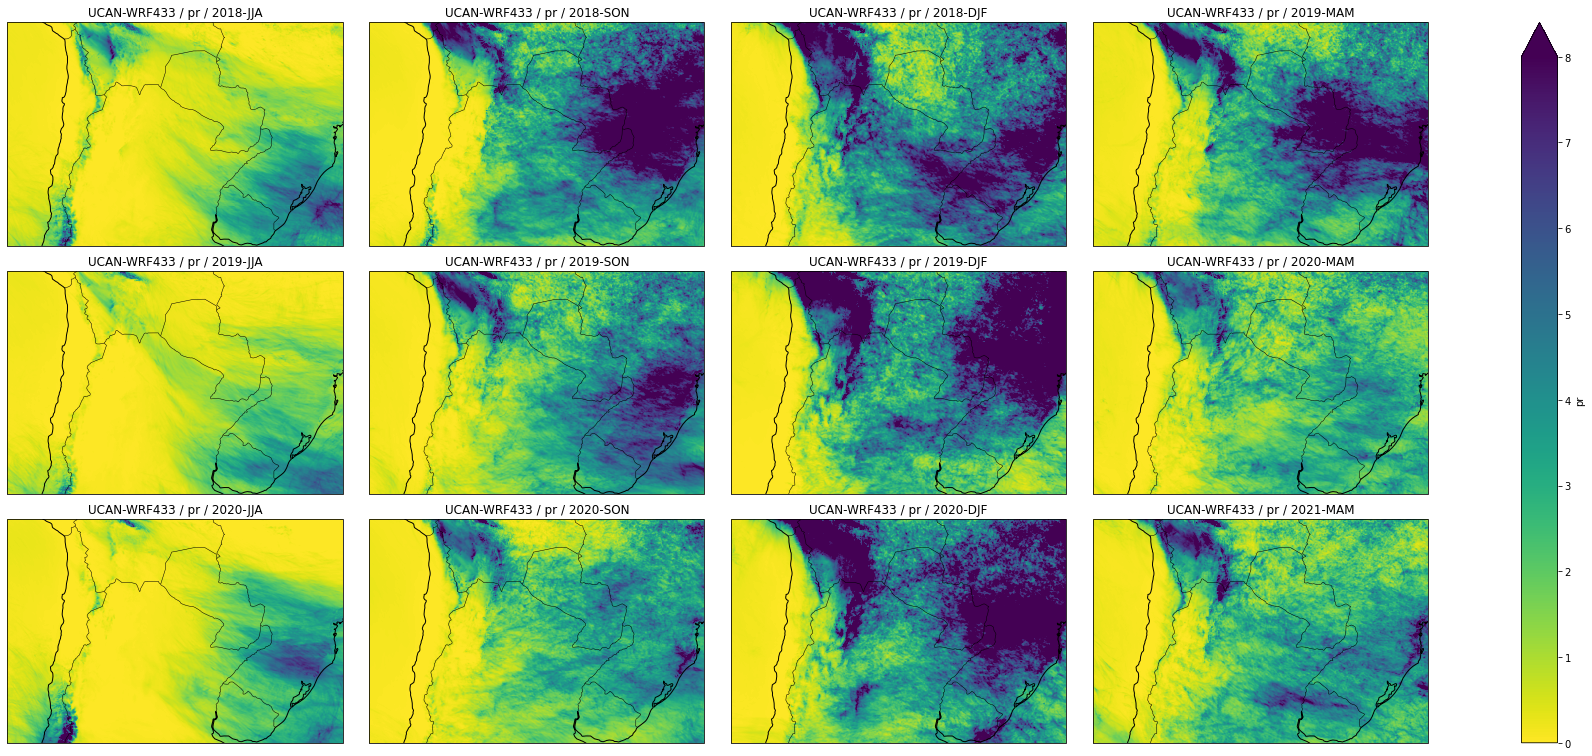

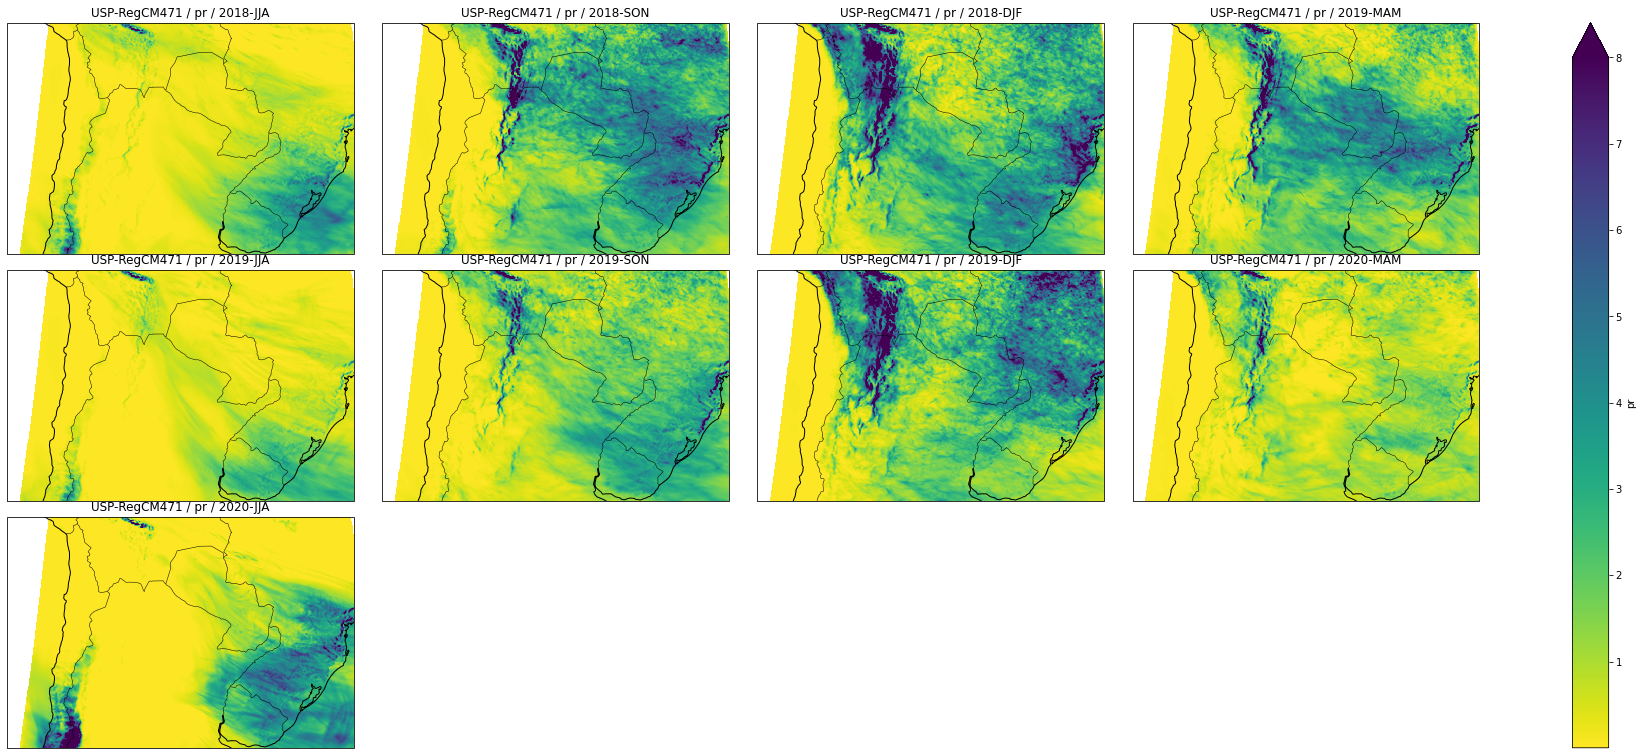

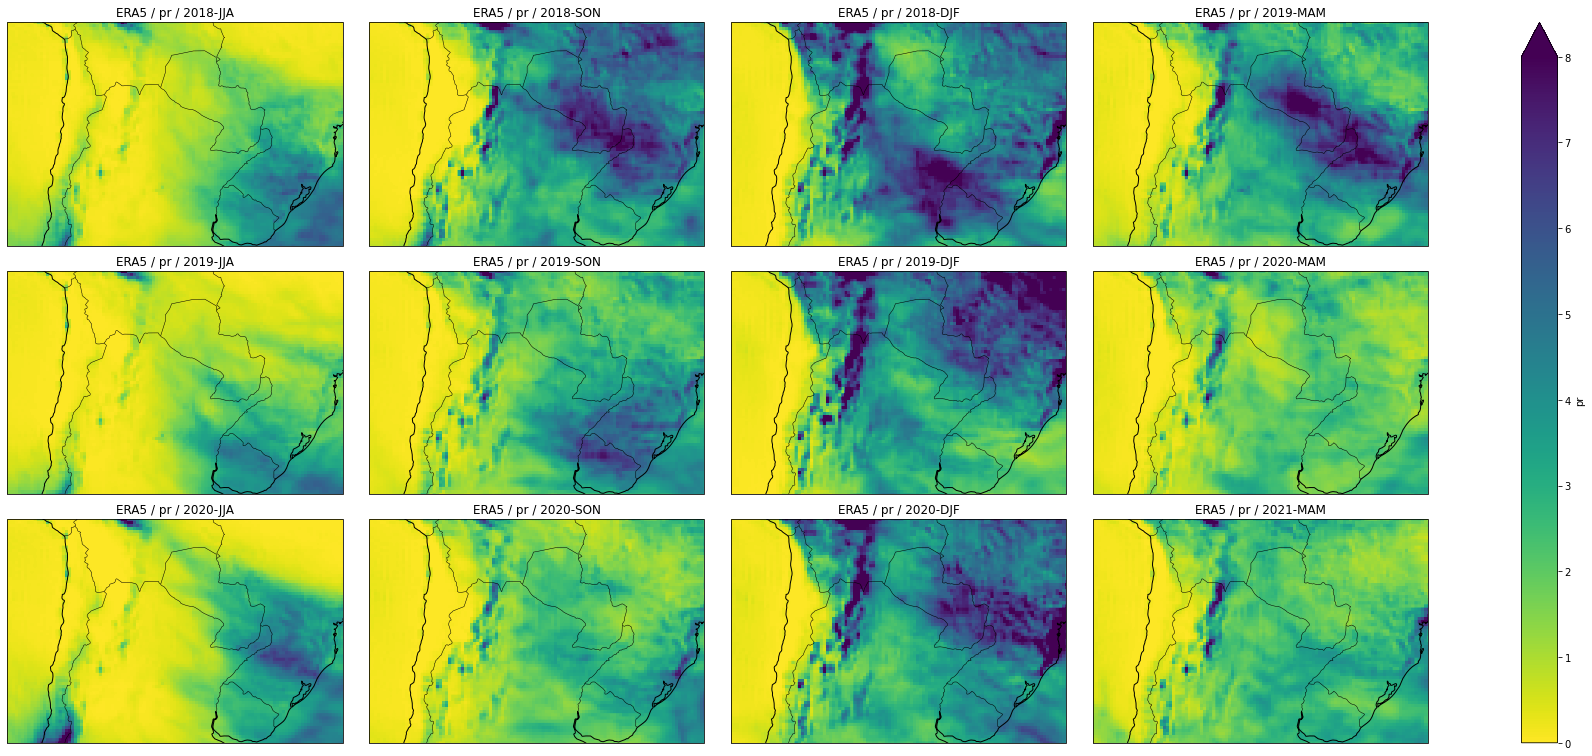

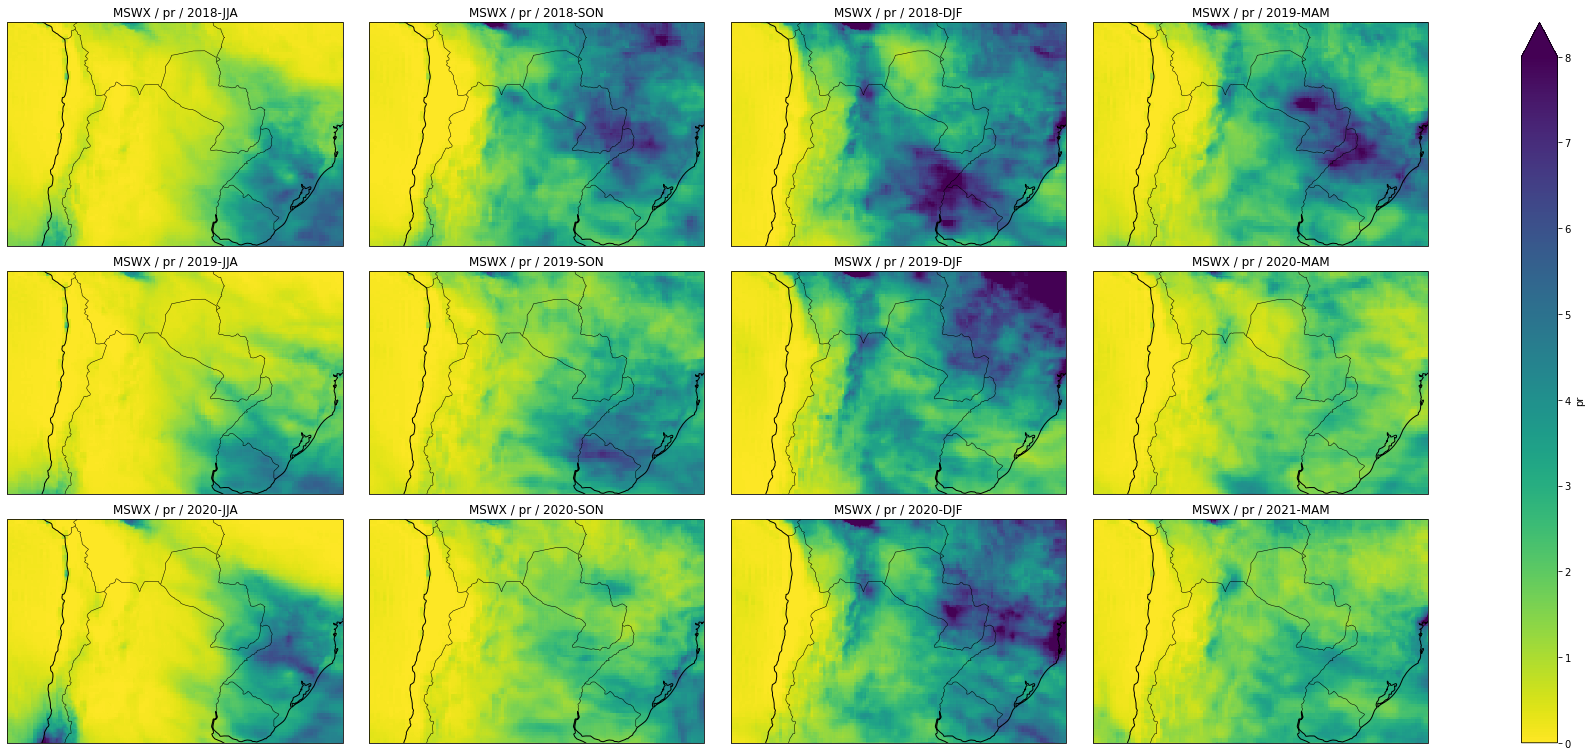

In [6]:
for dataset in ['UCAN-WRF433', 'USP-RegCM471', 'ERA5', 'MSWX']:
  print(f' ** {dataset}')
  yseasmean = load_yseasmean(f'yseasmean_{var}_{dataset}.nc', urls[dataset], var, scale[var])
  facet_plot(yseasmean.sel(dict(time=period)), f'{dataset} / {var}')

# Precipitation frequency

In [7]:
def facet_plot2(da, title):
  fg = da.plot(col='season', col_wrap=4,
    size=3.5, aspect=1.8, cmap=cm.viridis_r, vmax=1,
    subplot_kws = dict(projection=ccrs.PlateCarree())
  )
  for ax in fg.axes.ravel():
    ax.set_extent([-75, -48, -35, -17], crs=ccrs.PlateCarree())
    ax.add_feature(cfea.COASTLINE, linewidth=1)
    ax.add_feature(cfea.BORDERS, linewidth=0.5)
    ax.set_title(f'{title} / {ax.get_title()}')

[########################################] | 100% Completed |  1min 56.6s


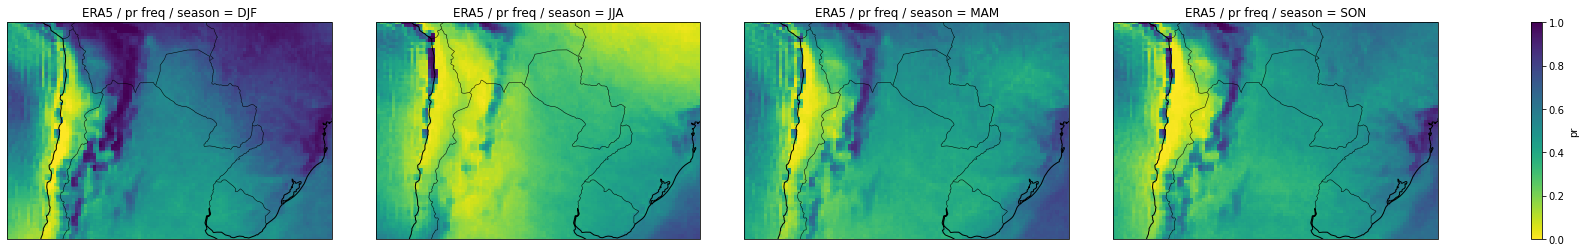

In [8]:
seasfreq = load_seasfreq('seasfreq_pr_ERA5.nc', urls['ERA5'], var, 86400.)
facet_plot2(seasfreq, 'ERA5 / pr freq')